In [1]:
import numpy as np
import sys
sys.path.insert(0, '../..') #This line adds '../..' to the path so we can import the net_framework python file
from RNN_model_GRAD import *
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
try:
    import ujson as json
except ImportError:
    import json

Having trained the network weights on the remote computer, and loading the weights

In [3]:
with open('weight_history.json') as f:
    weight_history = json.load(f)

In [6]:
weight_history.keys()

dict_keys(['noise weights', 'bias', 'input weights', 'connectivity matrix', 'input=.2', 'input=.8', 'input high to low', 'input low to high'])

Defining weights of the network. Final trained weights are in final_weights

In [13]:
noise_weights = np.array(weight_history['noise weights'])
bias_weights = np.array(weight_history['bias'])
input_weights = np.array(weight_history['input weights'])
output_weight_matrix = np.array(weight_history['output weights'])
connectivity_matrix = np.array(weight_history['connectivity matrix'])
final_weights = np.array(weight_history['input low to high'][-1])

In [15]:
num_nodes = 128
time_constant = 100 #ms
timestep = 10 #ms
noise_strength = .01

weight_matrix = tf.Variable(final_weights)
connectivity_matrix = tf.constant(connectivity_matrix)

input_weight_matrix = tf.constant(np.vstack((bias_weights, noise_weights, input_weights)))

def rule_input(time):
    #No input for now
    return 0
    
def bias(time):
    return 1
def noise(time):
    return np.sqrt(2 * time_constant/timestep) * noise_strength * np.random.normal(0, 1)


input_funcs = [bias, noise, rule_input]

init_activations = tf.constant(np.zeros((num_nodes, 1)))
output_weight_matrix = tf.constant(output_weight_matrix)
        
network = RNN(weight_matrix, connectivity_matrix, init_activations, output_weight_matrix, time_constant = time_constant,
             timestep = timestep,activation_func = keras.activations.relu, output_nonlinearity = lambda x : x)

Simulating Network Output

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 595.45it/s]


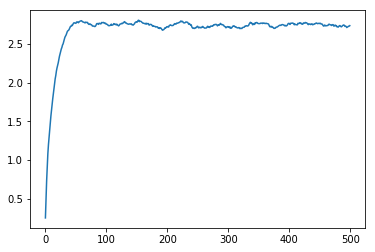

In [16]:
time = 5000 #ms
inputs = network.convert(time, input_funcs)
outputs, activations = network.simulate(time, inputs, input_weight_matrix)

outputs = tf.transpose(outputs).numpy()[0]
fig, ax = plt.subplots()
plt.plot(range(len(outputs)), outputs)
plt.show()

Now, simulating network activity to ensure that it works.

In [23]:
network.reset_activations()
def rule_input(time):
    #running for 5 seconds = 5000ms
    return .2 + np.random.normal(0, .05)
def target_func(time):
    #running for 5 seconds = 5000ms
    #Reverse of rule_input
    return .2

targets = network.convert(time, [target_func])
input_funcs[2] = rule_input
inputs = network.convert(time, input_funcs)

outputs, activations = network.simulate(time, inputs, input_weight_matrix)

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 538.67it/s]


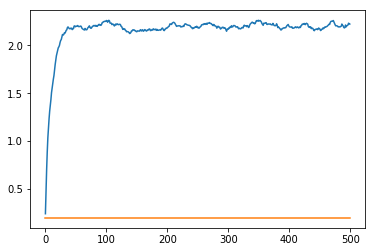

In [24]:

outputs = tf.transpose(outputs).numpy()[0]

fig, ax = plt.subplots()
plt.plot(range(len(outputs)), outputs)
plt.plot(range(len(outputs)), [target_func(t * timestep) for t in range(len(outputs))])
plt.show()

In [ ]:
activations = np.asarray(activations)
for i in range(4):
    fig, ax = plt.subplots()
    plt.plot(range(len(activations[:,i])), activations[:,i])
    plt.show()